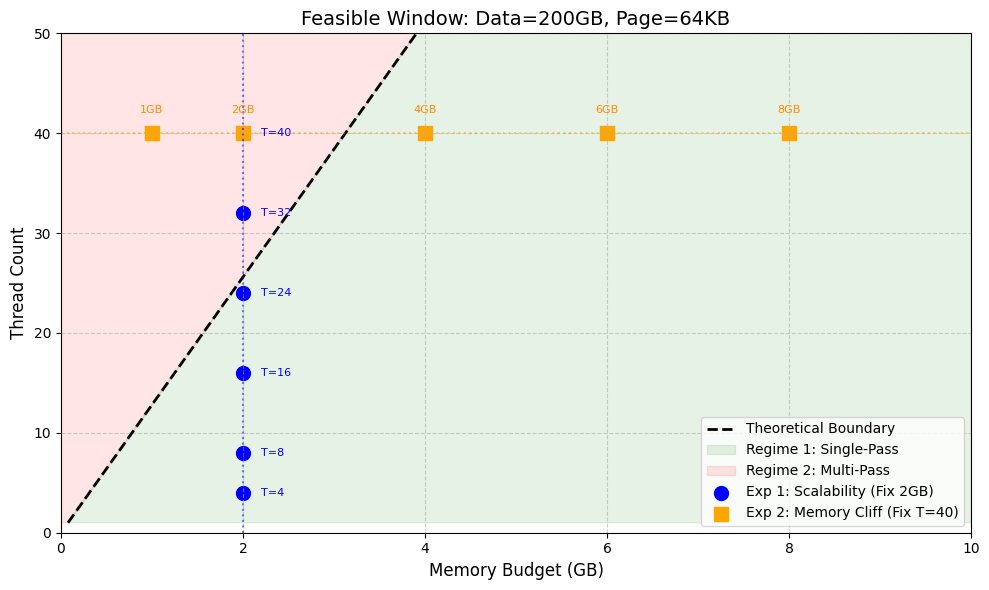


EXPERIMENT 1: SCALABILITY TRAP (Fixed Memory = 2 GB)
Goal: Show that increasing threads beyond the limit causes Multi-Pass


,Threads,Memory (GB),Run Size (MB),Est. Runs,Regime,Bench Fan-In
0,4,2,512.00,400,SAFE (Regime 1),20000
1,8,2,256.00,800,SAFE (Regime 1),20000
2,16,2,128.00,1600,SAFE (Regime 1),20000
3,24,2,85.33,2400,SAFE (Regime 1),20000
4,32,2,64.00,3200,FAIL (Regime 2),128
5,40,2,51.20,4000,FAIL (Regime 2),128



EXPERIMENT 2: MEMORY CLIFF (Fixed Threads = 40)
Goal: Show that 40 threads crash as memory drops below threshold


,Threads,Memory (GB),Run Size (MB),Est. Runs,Regime,Bench Fan-In
0,40,8,204.80,1000,SAFE (Regime 1),20000
1,40,6,153.60,1333,SAFE (Regime 1),20000
2,40,4,102.40,2000,SAFE (Regime 1),20000
3,40,2,51.20,4000,FAIL (Regime 2),128
4,40,1,25.60,8000,FAIL (Regime 2),128


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# ==========================================
# 1. SYSTEM & DATA CONFIGURATION
# ==========================================
DATA_SIZE_GB = 200        # Input Data Size (GB)
PAGE_SIZE_KB = 64         # Page Size (KB)
RS_FACTOR = 2.0           # Replacement Selection Factor (2.0 = 2x Memory)

# Constants for Math
D_bytes = DATA_SIZE_GB * 1024**3
P_bytes = PAGE_SIZE_KB * 1024

# ==========================================
# 2. THEORETICAL MODEL FUNCTIONS
# ==========================================
def get_min_memory_for_threads(t):
    """Returns minimal memory (GB) needed for single-pass merge with T threads."""
    # Formula: M >= T * sqrt(D * P) / sqrt(2)
    m_bytes = t * math.sqrt(D_bytes * P_bytes) / math.sqrt(RS_FACTOR)
    return m_bytes / 1024**3

def get_max_threads_for_memory(m_gb):
    """Returns max threads allowed for single-pass merge given M memory."""
    # Formula: T <= sqrt(2) * M / sqrt(D * P)
    m_bytes = m_gb * 1024**3
    t = math.sqrt(RS_FACTOR) * m_bytes / math.sqrt(D_bytes * P_bytes)
    return t

def get_regime_status(mem_gb, threads):
    """Determines if a config is in Regime 1 (Safe) or Regime 2 (Multi-Pass)."""
    # Calculate Run Size (MB)
    run_size_mb = (mem_gb * 1024) / threads
    
    # Calculate approx number of runs
    # Note: 200GB data / RunSize
    num_runs = (DATA_SIZE_GB * 1024) / run_size_mb
    
    # Calculate Theoretical Max Threads allowed for this memory
    max_safe_threads = get_max_threads_for_memory(mem_gb)
    
    status = "SAFE (Regime 1)" if threads <= max_safe_threads else "FAIL (Regime 2)"
    return run_size_mb, num_runs, status

# ==========================================
# 3. GENERATE PLOT DATA
# ==========================================
threads_y = np.linspace(1, 64, 100)
memory_x_curve = [get_min_memory_for_threads(t) for t in threads_y]

# Define Experiment Points
# Exp 1: Scalability Trap (Fixed 2GB RAM, Sweep Threads)
exp1_mem = 2
exp1_threads = [4, 8, 16, 24, 32, 40]
exp1_y = exp1_threads
exp1_x = [exp1_mem] * len(exp1_threads)

# Exp 2: Memory Cliff (Fixed 40 Threads, Sweep Memory)
exp2_threads = 40
exp2_mem = [8, 6, 4, 2, 1]
exp2_x = exp2_mem
exp2_y = [exp2_threads] * len(exp2_mem)

# ==========================================
# 4. PLOTTING
# ==========================================
plt.figure(figsize=(10, 6))

# Plot Regime Boundary
plt.plot(memory_x_curve, threads_y, 'k--', linewidth=2, label='Theoretical Boundary')
plt.fill_betweenx(threads_y, memory_x_curve, 35, color='green', alpha=0.1, label='Regime 1: Single-Pass')
plt.fill_betweenx(threads_y, 0, memory_x_curve, color='red', alpha=0.1, label='Regime 2: Multi-Pass')

# Plot Experiments
plt.scatter(exp1_x, exp1_y, color='blue', s=100, marker='o', label='Exp 1: Scalability (Fix 2GB)')
for t in exp1_threads:
    plt.text(exp1_mem + 0.2, t, f"T={t}", fontsize=8, color='blue', va='center')

plt.scatter(exp2_x, exp2_y, color='orange', s=100, marker='s', label='Exp 2: Memory Cliff (Fix T=40)')
for m in exp2_mem:
    plt.text(m, exp2_threads + 2, f"{m}GB", fontsize=8, color='darkorange', ha='center')

plt.title(f"Feasible Window: Data={DATA_SIZE_GB}GB, Page={PAGE_SIZE_KB}KB", fontsize=14)
plt.xlabel("Memory Budget (GB)", fontsize=12)
plt.ylabel("Thread Count", fontsize=12)
plt.xlim(0, 10)
plt.ylim(0, 50)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axvline(x=exp1_mem, color='blue', linestyle=':', alpha=0.5)
plt.axhline(y=exp2_threads, color='orange', linestyle=':', alpha=0.5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# ==========================================
# 5. GENERATE DATA TABLES
# ==========================================

print("\n" + "="*60)
print(f"EXPERIMENT 1: SCALABILITY TRAP (Fixed Memory = {exp1_mem} GB)")
print("Goal: Show that increasing threads beyond the limit causes Multi-Pass")
print("="*60)

exp1_data = []
for t in exp1_threads:
    rs_mb, n_runs, status = get_regime_status(exp1_mem, t)
    
    # Recommendation for script:
    # If SAFE -> FanIn = 20000 (Force Single Pass)
    # If FAIL -> FanIn = 128 (Allow Multi Pass)
    rec_fanin = 20000 if "SAFE" in status else 128
    
    exp1_data.append({
        "Threads": t,
        "Memory (GB)": exp1_mem,
        "Run Size (MB)": f"{rs_mb:.2f}",
        "Est. Runs": int(n_runs),
        "Regime": status,
        "Bench Fan-In": rec_fanin
    })

df1 = pd.DataFrame(exp1_data)
display(df1)

print("\n" + "="*60)
print(f"EXPERIMENT 2: MEMORY CLIFF (Fixed Threads = {exp2_threads})")
print("Goal: Show that 40 threads crash as memory drops below threshold")
print("="*60)

exp2_data = []
for m in exp2_mem:
    rs_mb, n_runs, status = get_regime_status(m, exp2_threads)
    rec_fanin = 20000 if "SAFE" in status else 128
    
    exp2_data.append({
        "Threads": exp2_threads,
        "Memory (GB)": m,
        "Run Size (MB)": f"{rs_mb:.2f}",
        "Est. Runs": int(n_runs),
        "Regime": status,
        "Bench Fan-In": rec_fanin
    })

df2 = pd.DataFrame(exp2_data)
display(df2)